<a href="https://colab.research.google.com/github/Shuchangd/MUSA611-CPLN692-week1/blob/master/PrjA1_DSTL_ImgChannelsMasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tifffile

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [0]:
import sys
import pandas as pd
import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff
import matplotlib
import matplotlib.pyplot as plt
import pdb

In [0]:
## Functions

## Calculate scaling in x and y for vector to raster transformation
def getScaleXY(imgSize, xMax, yMin):
    h, w = imgSize
    wc = w * (w / (w + 1))
    hc = h * (h / (h + 1))
    return wc / xMax, hc / yMin


In [0]:
## Intensity normalize images 
def scaleImg(imgIn, percLow, percHigh, isMaxRange=0):
    w, h, d = imgIn.shape
    imgOut = np.reshape(imgIn, [w * h, d]).astype(np.float64)
    mins = np.percentile(imgOut, percLow, axis=0)
#    maxs = np.percentile(imgOut, percHigh, axis=0)
    maxs = np.percentile(imgOut.flatten(), percHigh)
    difs = maxs - mins
    
    if isMaxRange==1:
      imgOut = (imgOut - mins[None, :]) / difs[None, :]
      imgOut = imgOut / difs[None, :]
    else:
#      imgOut = imgOut / maxs[None, :]
      imgOut = imgOut / maxs
      
    imgOut = np.reshape(imgOut, [w, h, d])
    print(np.max(imgOut[:,:,0].flatten()))
    imgOut = imgOut.clip(0, 1)
    imgOut = (imgOut * 255).round().astype(np.uint8)
    return imgOut


In [0]:
def scaleImgPerc(imgIn):
    w, h, d = imgIn.shape
    imgIn = np.reshape(imgIn, [w * h, d]).astype(np.float64)
    # Get 1st and 99th percentile
    mins = np.percentile(imgIn, 1, axis=0)
    maxs = np.percentile(imgIn, 99, axis=0) - mins
    imgIn = (imgIn - mins[None, :]) / maxs[None, :]
    imgIn = np.reshape(imgIn, [w, h, d])
    imgIn = imgIn.clip(0, 1)
    return imgIn


In [0]:
## Create a binary mask from a given polygon
def polyToMask(imgSize, polygons):
    labelMask = np.zeros(imgSize, np.uint8)
    if not polygons:
        print('    EMPTY poly object')
        return labelMask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
    cv2.fillPoly(labelMask, exteriors, 1)
    cv2.fillPoly(labelMask, interiors, 0)
    return labelMask


In [0]:
############################################
## Hard coded paths and vars
BDIR = '/content/drive/My Drive/PrjData/Prj_DSTL/Data_Init'
IMGDIR = BDIR + '/Images_SmallSampleSize'
IMG_LIST = IMGDIR + '/ListID.csv'
  
CSV_POLY = BDIR + '/' + 'train_wkt_v4.csv'
CSV_GS = BDIR + '/' + 'grid_sizes.csv'
CSV_CTYPE = BDIR + '/' + 'DSTL_ClassTypes.csv'


In [0]:
############################################
## Main

## Read csv files
dfP = pd.read_csv(CSV_POLY)
dfG = pd.read_csv(CSV_GS, names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
dfC = pd.read_csv(CSV_CTYPE)

dfID = pd.read_csv(IMG_LIST)


In [0]:
dfP.head()

ImageId  ClassType                                    MultipolygonWKT
0  6040_2_2          1                                 MULTIPOLYGON EMPTY
1  6040_2_2          2                                 MULTIPOLYGON EMPTY
2  6040_2_2          3                                 MULTIPOLYGON EMPTY
3  6040_2_2          4  MULTIPOLYGON (((0.003025 -0.007879000000000001...
4  6040_2_2          5  MULTIPOLYGON (((0.005311 -0.009044999999999999...

In [0]:
dfG.head()

ImageId      Xmax     Ymin
0  6120_2_4  0.009180 -0.00904
1  6120_2_3  0.009169 -0.00904
2  6120_2_2  0.009188 -0.00904
3  6120_2_1  0.009188 -0.00904
4  6120_2_0  0.009188 -0.00904

In [0]:
dfC.head()

Index      Class
0      0       None
1      1  Buildings
2      2    Manmade
3      3      Road 
4      4      Track

In [0]:
## Read image
IMGID = '6100_2_3'

imgRGB = tiff.imread(IMGDIR + '/' + IMGID + '.tif').transpose([1, 2, 0])
imgSc = scaleImgPerc(imgRGB)
imgSc.shape

(3349, 3391, 3)

In [0]:
tiff.imread(IMGDIR + '/' + IMGID + '.tif').shape


(3, 3349, 3391)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f4a67dbf198>)

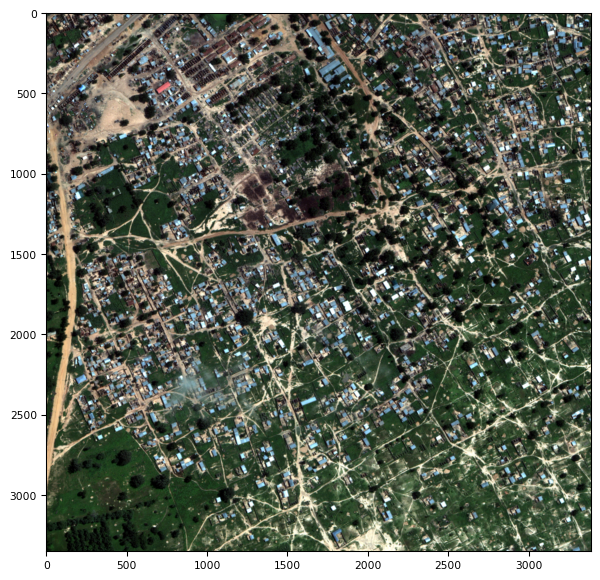

In [0]:
tiff.imshow(imgSc)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f4a684cd9e8>)

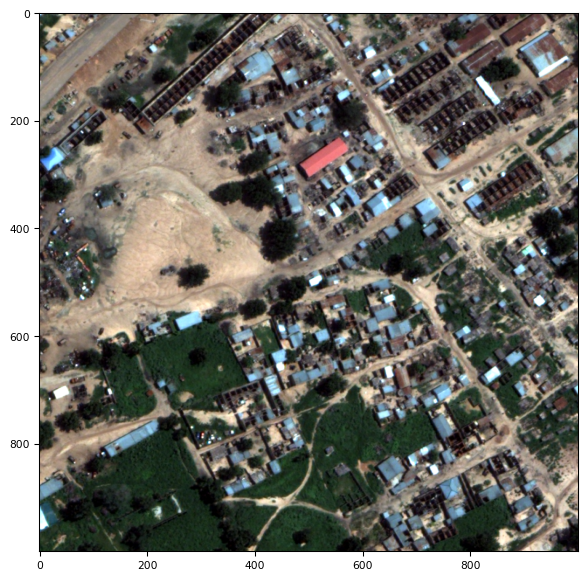

In [0]:
imgC = imgSc[200:1200, 200:1200,:]
tiff.imshow(imgC)

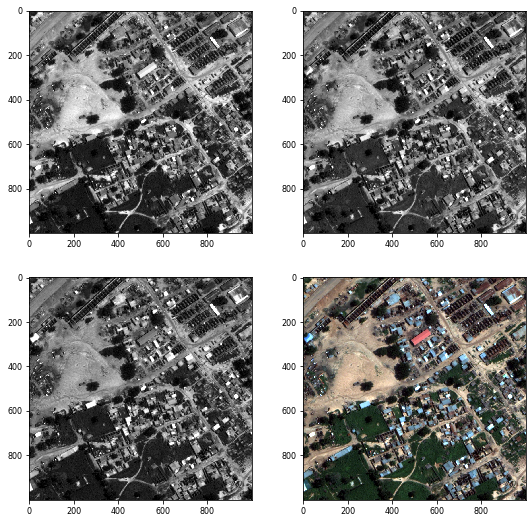

In [0]:
fig, ax = plt.subplots(2, 2, figsize=[9,9])
ax[0,0].imshow(imgC[:,:,0], cmap='gray')
ax[0,1].imshow(imgC[:,:,1], cmap='gray')
ax[1,0].imshow(imgC[:,:,2], cmap='gray')
ax[1,1].imshow(imgC)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f4a686e7978>)

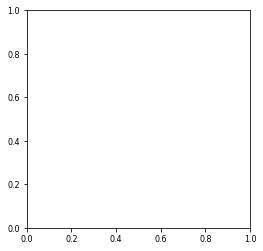

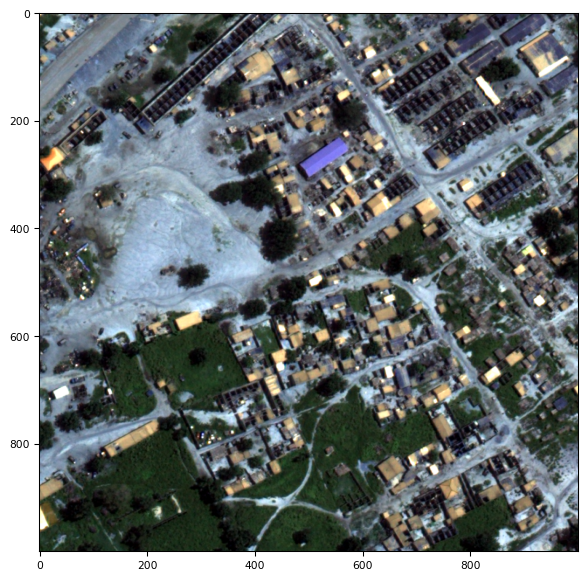

In [0]:
fig, ax = plt.subplots(1, 1, figsize=[4,4])

imgCTmp = imgC[:, :, [2,1,0]]
tiff.imshow(imgCTmp)

In [0]:
## For each image create a mask with labels of all objects
imgIds = dfID.IMG_ID.tolist()

ListImgAll = []
ListLabelAll = []
for i, tmpId in enumerate(imgIds):
#for i, tmpId in enumerate(imgIds[0:4]):

    print('\nImage no ' + str(i) + ': ' + tmpId)

    # Read grid size
    xMax = dfG[dfG.ImageId == tmpId].Xmax
    yMin = dfG[dfG.ImageId == tmpId].Ymin

    # Read RGB image, scale intensities
    imgRGB = tiff.imread(IMGDIR + '/' + tmpId + '.tif').transpose([1, 2, 0])
    #imgSc = scaleImg(imgRGB, 0, 100, 0)
    imgSc = scaleImgPerc(imgRGB)

    imgSize = imgRGB.shape[:2]
    imgX = imgSize[0]
    imgY = imgSize[1]

    # Calculate scale factors
    scX, scY = getScaleXY(imgSize, xMax, yMin)

    # Create a mask with all labels
    maskAll = np.zeros([imgX, imgY, 11], np.uint8)
    dfSel = dfP[dfP.ImageId == tmpId]
    for j, tmpRow in dfSel.iterrows():

        print(' Object no ' + str(j) + ': ' + str(tmpRow.ClassType))
        
        polyInit = shapely.wkt.loads(tmpRow.MultipolygonWKT)

        # Scale polygons
        polySc = shapely.affinity.scale(polyInit, xfact=scX, yfact=scY, origin=(0, 0, 0))
        
        maskAll[:,:,tmpRow.ClassType] = polyToMask(imgSize, polySc)
        
    # Select the object in each pixel
    maskComb = np.argmax(maskAll, axis=2).astype(np.uint8)

    # Append img and mask to out lists
    ListImgAll.append(imgSc)
    ListLabelAll.append(maskComb)




Image no 0: 6040_2_2
 Object no 0: 1
    EMPTY poly object
 Object no 1: 2
    EMPTY poly object
 Object no 2: 3
    EMPTY poly object
 Object no 3: 4
 Object no 4: 5
 Object no 5: 6
    EMPTY poly object
 Object no 6: 7
    EMPTY poly object
 Object no 7: 8
    EMPTY poly object
 Object no 8: 9
    EMPTY poly object
 Object no 9: 10
    EMPTY poly object

Image no 1: 6070_2_3
 Object no 210: 1
 Object no 211: 2
 Object no 212: 3
 Object no 213: 4
    EMPTY poly object
 Object no 214: 5
 Object no 215: 6
    EMPTY poly object
 Object no 216: 7
 Object no 217: 8
 Object no 218: 9
    EMPTY poly object
 Object no 219: 10

Image no 2: 6100_2_3
 Object no 110: 1
 Object no 111: 2
 Object no 112: 3
 Object no 113: 4
 Object no 114: 5
 Object no 115: 6
    EMPTY poly object
 Object no 116: 7
    EMPTY poly object
 Object no 117: 8
 Object no 118: 9
 Object no 119: 10

Image no 3: 6150_2_3
 Object no 120: 1
    EMPTY poly object
 Object no 121: 2
 Object no 122: 3
    EMPTY poly object
 Obje

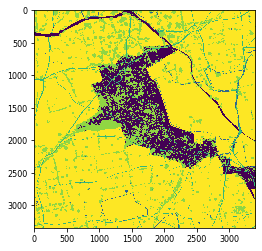

In [0]:
cmap = matplotlib.colors.ListedColormap(['w', 'k', 'r', '#FF8C00','y','g','#FFFF00','b','c','m','#FF8EFC']) #10 classes

plt.imshow(maskComb)

In [0]:
dfC.Class.tolist()

['None',
 'Buildings',
 'Manmade',
 'Road ',
 'Track',
 'Trees',
 'Crops',
 'Waterway ',
 'StandingWater',
 'VehicleLarge',
 'VehicleSmall']

In [0]:
aa=np.array([3,4,11,6,7,11,3,4])
np.argmax(aa)

2

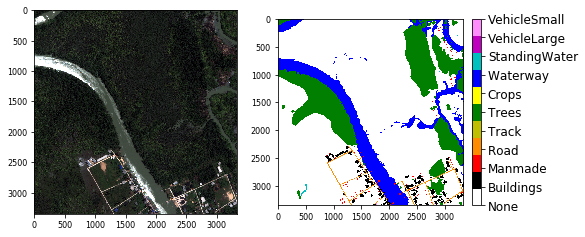

In [0]:
## Show masked area
img = ListImgAll[1]
mask = ListLabelAll[1]

cmap = matplotlib.colors.ListedColormap(['w', 'k', 'r', '#FF8C00','y','g','#FFFF00','b','c','m','#FF8EFC']) #10 classes

fig, ax = plt.subplots(1, 2, figsize=[8,8])
pImg = ax[0].imshow(img)
pMask = ax[1].imshow(mask, cmap=cmap)
cbar = fig.colorbar(pMask, ax=ax[1], fraction=0.046, pad=0.04, ticks=np.arange(0,11))
cbar.ax.set_yticklabels(dfC.Class.tolist())
cbar.ax.tick_params(labelsize=12)


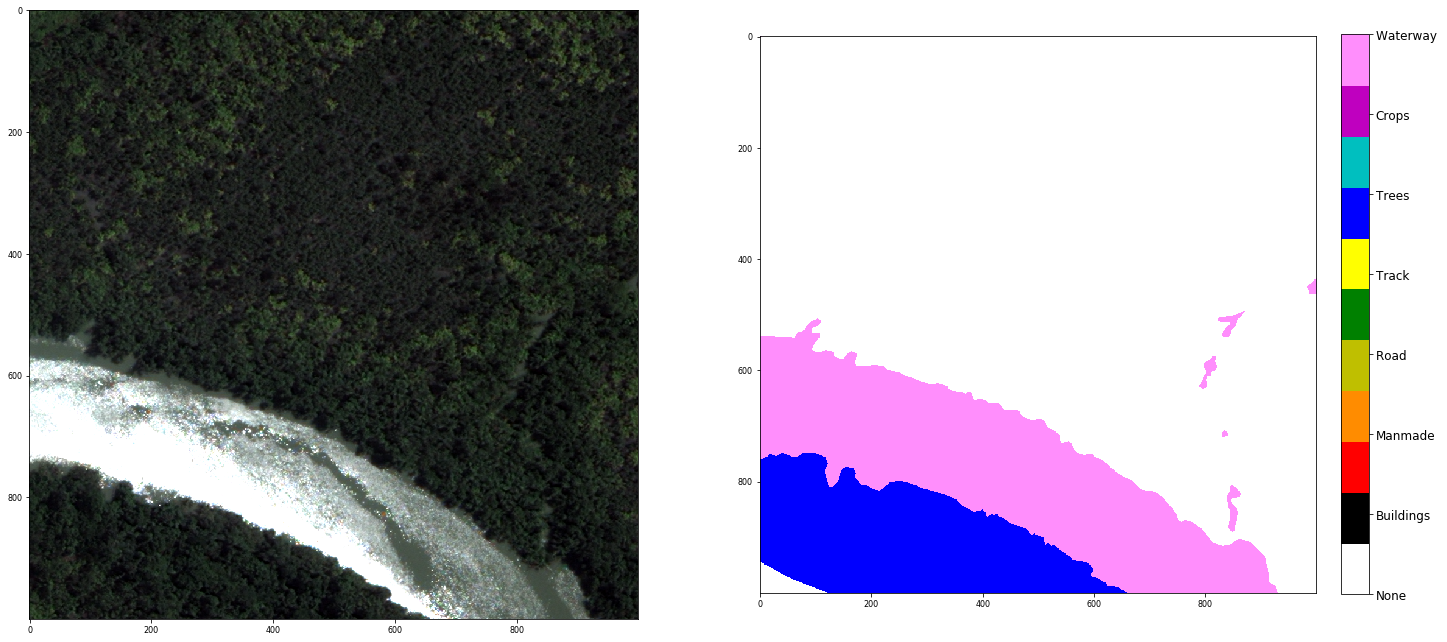

In [0]:
## Show masked area
img = ListImgAll[1][200:1200, 200:1200,:]
mask = ListLabelAll[1][200:1200, 200:1200]

cmap = matplotlib.colors.ListedColormap(['w', 'k', 'r', '#FF8C00','y','g','#FFFF00','b','c','m','#FF8EFC']) #10 classes

fig, ax = plt.subplots(1, 2, figsize=[24,24])
pImg = ax[0].imshow(img)
pMask = ax[1].imshow(mask, cmap=cmap)
cbar = fig.colorbar(pMask, ax=ax[1], fraction=0.046, pad=0.04, ticks=np.arange(0,11))
cbar.ax.set_yticklabels(dfC.Class.tolist())
cbar.ax.tick_params(labelsize=12)
